# Obesity Classifier Part Two

# Imports

In [133]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import entropy

# MLP
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer

# Functions

In [152]:

def spot_check_models(X_train_scaled, X_test_scaled, y_train_encoded, y_test_encoded):
    """
    This a quick way to spot check relevant algorithms to gain an understanding of 
    the dataset and which models handle the distribution well.

    Args:
        X_train_scaled (_type_): _description_
        X_test_scaled (_type_): _description_
        y_train_encoded (_type_): _description_
        y_test_encoded (_type_): _description_

    Returns:
        _type_: Sorted dataframe on accuracy scores.
    """
    models = {
        
        "GaussianNB": GaussianNB(),
        "LDA":LinearDiscriminantAnalysis(),
        "GPC":GaussianProcessClassifier(),
        
        "LogisticRegression": LogisticRegression(max_iter=10000),
        "SVC": SVC(),
        "KNeighborsClassifier": KNeighborsClassifier(),
        
        "DecisionTreeClassifier": DecisionTreeClassifier(random_state=42),
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42),
        "XGB":XGBClassifier()
    }

    # Create an empty DataFrame to store model performance
    model_performance = []

    for name, model in models.items():
        model.fit(X_train_scaled, y_train_encoded)
        predictions = model.predict(X_test_scaled)
        accuracy = accuracy_score(y_test_encoded, predictions)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy
        })

    # For the Sequential model
    sequential_model = Sequential()
    sequential_model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    sequential_model.add(Dense(32, activation='relu'))
    sequential_model.add(Dense(1, activation='sigmoid'))
    sequential_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    sequential_model.fit(X_train_scaled, y_train_encoded, epochs=50, batch_size=10, verbose=0)
    loss, accuracy = sequential_model.evaluate(X_test_scaled, y_test_encoded)
    model_performance.append({
        "Model": "Sequential",
        "Accuracy": accuracy
    })

    # Convert the model_performance to a DataFrame
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Accuracy", ascending=False)


def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier()
  }
  selected_models = []
  
  for key, val in models.items():
    if key in names:
      selected_models.append(val)
  
  return selected_models

def evaluate_model(X, y, model, metric):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def labels_to_probabilities(y):
    values, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return probabilities

def calculate_entropy(df:pd.DataFrame)-> pd.DataFrame:
  """_summary_

  Args:
      df (pd.DataFrame): Pandas DataFrame

  Returns:
      pd.DataFrame: THe Entropy level of all models
  """

  column_entropy_info = {}
  for col in df.columns:
    probabilities = labels_to_probabilities(df[col])
    entropy_value = entropy(probabilities, base=2)
    column_entropy_info[col] = {
          'entropy': entropy_value
      }

  return pd.DataFrame(column_entropy_info)

# EDA Analysis

In [6]:
df = pd.read_csv("data.csv")
df

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.000000,Female,1.620000,64.000000,no,no,2.0,3.0,no,no,2.000000,yes,0.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
1,21.000000,Female,1.520000,56.000000,Sometimes,no,3.0,3.0,yes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,23.000000,Male,1.800000,77.000000,Frequently,no,2.0,3.0,no,no,2.000000,yes,2.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
3,27.000000,Male,1.800000,87.000000,Frequently,no,3.0,3.0,no,no,2.000000,no,2.000000,0.000000,Sometimes,Walking,Overweight_Level_I
4,22.000000,Male,1.780000,89.800000,Sometimes,no,2.0,1.0,no,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,Female,1.710730,131.408528,Sometimes,yes,3.0,3.0,no,no,1.728139,yes,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,21.982942,Female,1.748584,133.742943,Sometimes,yes,3.0,3.0,no,no,2.005130,yes,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,22.524036,Female,1.752206,133.689352,Sometimes,yes,3.0,3.0,no,no,2.054193,yes,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,24.361936,Female,1.739450,133.346641,Sometimes,yes,3.0,3.0,no,no,2.852339,yes,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [7]:
df.isna().sum()

Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64

In [8]:
df.duplicated().sum()

24

In [9]:
df.drop_duplicates(inplace=True)

In [17]:
target = df.values[:,-1]

counter = Counter(target)

for k, v in counter.items():
  per = v/ len(target) * 100
  print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v,per))

Class=Normal_Weight, Count=282, Percentage=13.512%
Class=Overweight_Level_I, Count=276, Percentage=13.225%
Class=Overweight_Level_II, Count=290, Percentage=13.896%
Class=Obesity_Type_I, Count=351, Percentage=16.818%
Class=Insufficient_Weight, Count=267, Percentage=12.793%
Class=Obesity_Type_II, Count=297, Percentage=14.231%
Class=Obesity_Type_III, Count=324, Percentage=15.525%


# Fairly Balanced dataset

In [18]:
df.dtypes

Age                               float64
Gender                             object
Height                            float64
Weight                            float64
CALC                               object
FAVC                               object
FCVC                              float64
NCP                               float64
SCC                                object
SMOKE                              object
CH2O                              float64
family_history_with_overweight     object
FAF                               float64
TUE                               float64
CAEC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object

In [26]:
categorical_features = df.select_dtypes(include="object")
continuous_features = df.select_dtypes(include="float64")

In [74]:
from collections import defaultdict

def convert_categorical_to_numerical(column_values:list):
  """
  Takes categorical columns and returns them into one hot encoding columns
  without exploding the amount of columns

  Args:
      column_values (list): tuple list of index, value

  Returns:
      Dictionary Key valued pair
  """
  converted_dict = defaultdict(list)
  
  for k, v in column_values:
    converted_dict[k] = v
  return converted_dict

binary_columns, mapping_dict = [], {}
for col in categorical_features.columns:
  unique_columns_values = categorical_features[col].unique()
  print(f" Col: {col}, Unique list: {unique_columns_values}")
  if len(unique_columns_values) ==2:
    binary_columns.append(col)
  else:
    dict_values = [(value, idx )for (idx, value) in enumerate(sorted(unique_columns_values))]
    mapping_dict[col] = convert_categorical_to_numerical(dict_values)

 Col: Gender, Unique list: ['Female' 'Male']
 Col: CALC, Unique list: ['no' 'Sometimes' 'Frequently' 'Always']
 Col: FAVC, Unique list: ['no' 'yes']
 Col: SCC, Unique list: ['no' 'yes']
 Col: SMOKE, Unique list: ['no' 'yes']
 Col: family_history_with_overweight, Unique list: ['yes' 'no']
 Col: CAEC, Unique list: ['Sometimes' 'Frequently' 'Always' 'no']
 Col: MTRANS, Unique list: ['Public_Transportation' 'Walking' 'Automobile' 'Motorbike' 'Bike']
 Col: NObeyesdad, Unique list: ['Normal_Weight' 'Overweight_Level_I' 'Overweight_Level_II'
 'Obesity_Type_I' 'Insufficient_Weight' 'Obesity_Type_II'
 'Obesity_Type_III']


# Feature Encoding

In [89]:
for k, v in mapping_dict.items():
  print(k,v)

CALC defaultdict(<class 'list'>, {'Always': 0, 'Frequently': 1, 'Sometimes': 2, 'no': 3})
CAEC defaultdict(<class 'list'>, {'Always': 0, 'Frequently': 1, 'Sometimes': 2, 'no': 3})
MTRANS defaultdict(<class 'list'>, {'Automobile': 0, 'Bike': 1, 'Motorbike': 2, 'Public_Transportation': 3, 'Walking': 4})
NObeyesdad defaultdict(<class 'list'>, {'Insufficient_Weight': 0, 'Normal_Weight': 1, 'Obesity_Type_I': 2, 'Obesity_Type_II': 3, 'Obesity_Type_III': 4, 'Overweight_Level_I': 5, 'Overweight_Level_II': 6})


In [90]:
# Create copy of Dataframe for feature manipulation
replicate_df = df.copy()
replicate_df

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.000000,Female,1.620000,64.000000,no,no,2.0,3.0,no,no,2.000000,yes,0.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
1,21.000000,Female,1.520000,56.000000,Sometimes,no,3.0,3.0,yes,yes,3.000000,yes,3.000000,0.000000,Sometimes,Public_Transportation,Normal_Weight
2,23.000000,Male,1.800000,77.000000,Frequently,no,2.0,3.0,no,no,2.000000,yes,2.000000,1.000000,Sometimes,Public_Transportation,Normal_Weight
3,27.000000,Male,1.800000,87.000000,Frequently,no,3.0,3.0,no,no,2.000000,no,2.000000,0.000000,Sometimes,Walking,Overweight_Level_I
4,22.000000,Male,1.780000,89.800000,Sometimes,no,2.0,1.0,no,no,2.000000,no,0.000000,0.000000,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,Female,1.710730,131.408528,Sometimes,yes,3.0,3.0,no,no,1.728139,yes,1.676269,0.906247,Sometimes,Public_Transportation,Obesity_Type_III
2107,21.982942,Female,1.748584,133.742943,Sometimes,yes,3.0,3.0,no,no,2.005130,yes,1.341390,0.599270,Sometimes,Public_Transportation,Obesity_Type_III
2108,22.524036,Female,1.752206,133.689352,Sometimes,yes,3.0,3.0,no,no,2.054193,yes,1.414209,0.646288,Sometimes,Public_Transportation,Obesity_Type_III
2109,24.361936,Female,1.739450,133.346641,Sometimes,yes,3.0,3.0,no,no,2.852339,yes,1.139107,0.586035,Sometimes,Public_Transportation,Obesity_Type_III


In [91]:
for col in binary_columns:
  if col == "Gender":
    replicate_df[col] = replicate_df[col].apply(lambda x: 0 if x == "Female" else 1)
  else:
    replicate_df[col] = replicate_df[col].apply(lambda x: 0 if x == "no" else 1)

for k, v in mapping_dict.items():
  replicate_df[k] = replicate_df[k].apply(lambda x: v[x])


In [92]:
replicate_df

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.000000,0,1.620000,64.000000,3,0,2.0,3.0,0,0,2.000000,1,0.000000,1.000000,2,3,1
1,21.000000,0,1.520000,56.000000,2,0,3.0,3.0,1,1,3.000000,1,3.000000,0.000000,2,3,1
2,23.000000,1,1.800000,77.000000,1,0,2.0,3.0,0,0,2.000000,1,2.000000,1.000000,2,3,1
3,27.000000,1,1.800000,87.000000,1,0,3.0,3.0,0,0,2.000000,0,2.000000,0.000000,2,4,5
4,22.000000,1,1.780000,89.800000,2,0,2.0,1.0,0,0,2.000000,0,0.000000,0.000000,2,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,20.976842,0,1.710730,131.408528,2,1,3.0,3.0,0,0,1.728139,1,1.676269,0.906247,2,3,4
2107,21.982942,0,1.748584,133.742943,2,1,3.0,3.0,0,0,2.005130,1,1.341390,0.599270,2,3,4
2108,22.524036,0,1.752206,133.689352,2,1,3.0,3.0,0,0,2.054193,1,1.414209,0.646288,2,3,4
2109,24.361936,0,1.739450,133.346641,2,1,3.0,3.0,0,0,2.852339,1,1.139107,0.586035,2,3,4


In [93]:
replicate_df.dtypes

Age                               float64
Gender                              int64
Height                            float64
Weight                            float64
CALC                                int64
FAVC                                int64
FCVC                              float64
NCP                               float64
SCC                                 int64
SMOKE                               int64
CH2O                              float64
family_history_with_overweight      int64
FAF                               float64
TUE                               float64
CAEC                                int64
MTRANS                              int64
NObeyesdad                          int64
dtype: object

In [123]:
replicate_df.describe()

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
count,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000,2087.000000
mean,24.353090,0.504073,1.702674,86.858730,2.270244,0.883565,2.421466,2.701179,0.045999,0.021083,2.004749,0.825108,1.012812,0.663035,1.853857,2.358888,3.014375
std,6.368801,0.500103,0.093186,26.190847,0.517008,0.320823,0.534737,0.764614,0.209533,0.143695,0.608284,0.379966,0.853475,0.608153,0.459494,1.265402,1.948470
min,14.000000,0.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.915937,0.000000,1.630178,66.000000,2.000000,1.000000,2.000000,2.697467,0.000000,0.000000,1.590922,1.000000,0.124505,0.000000,2.000000,3.000000,1.000000
50%,22.847618,1.000000,1.701584,83.101100,2.000000,1.000000,2.396265,3.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.630866,2.000000,3.000000,3.000000
75%,26.000000,1.000000,1.769491,108.015907,3.000000,1.000000,3.000000,3.000000,0.000000,0.000000,2.466193,1.000000,1.678102,1.000000,2.000000,3.000000,5.000000
max,61.000000,1.000000,1.980000,173.000000,3.000000,1.000000,3.000000,4.000000,1.000000,1.000000,3.000000,1.000000,3.000000,2.000000,3.000000,4.000000,6.000000


# Heat Map

<Axes: >

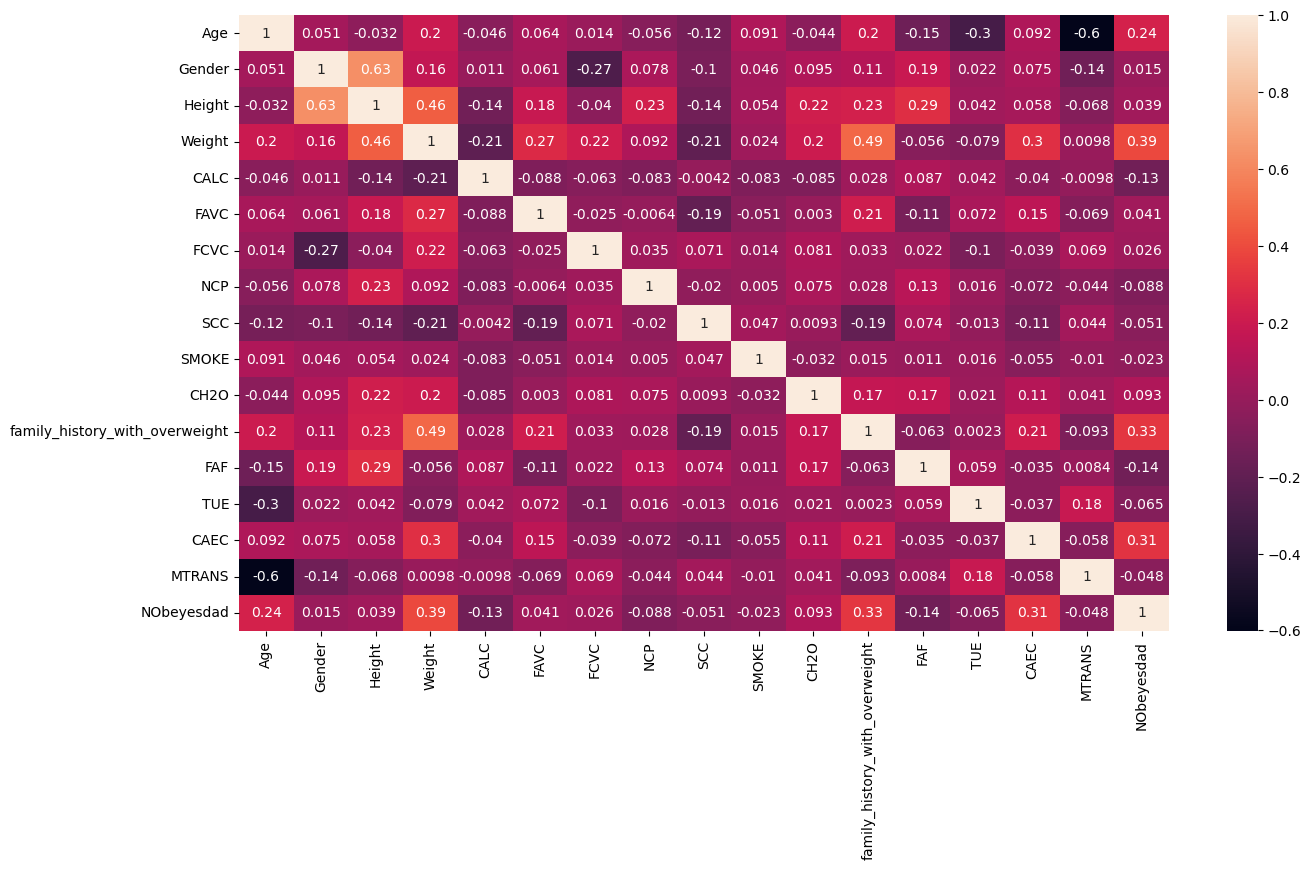

In [94]:
plt.figure(figsize=(15,8))
sns.heatmap(data=replicate_df.corr(), annot=True)

# Histogram for Continuous features

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/2702308912.py:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/27023

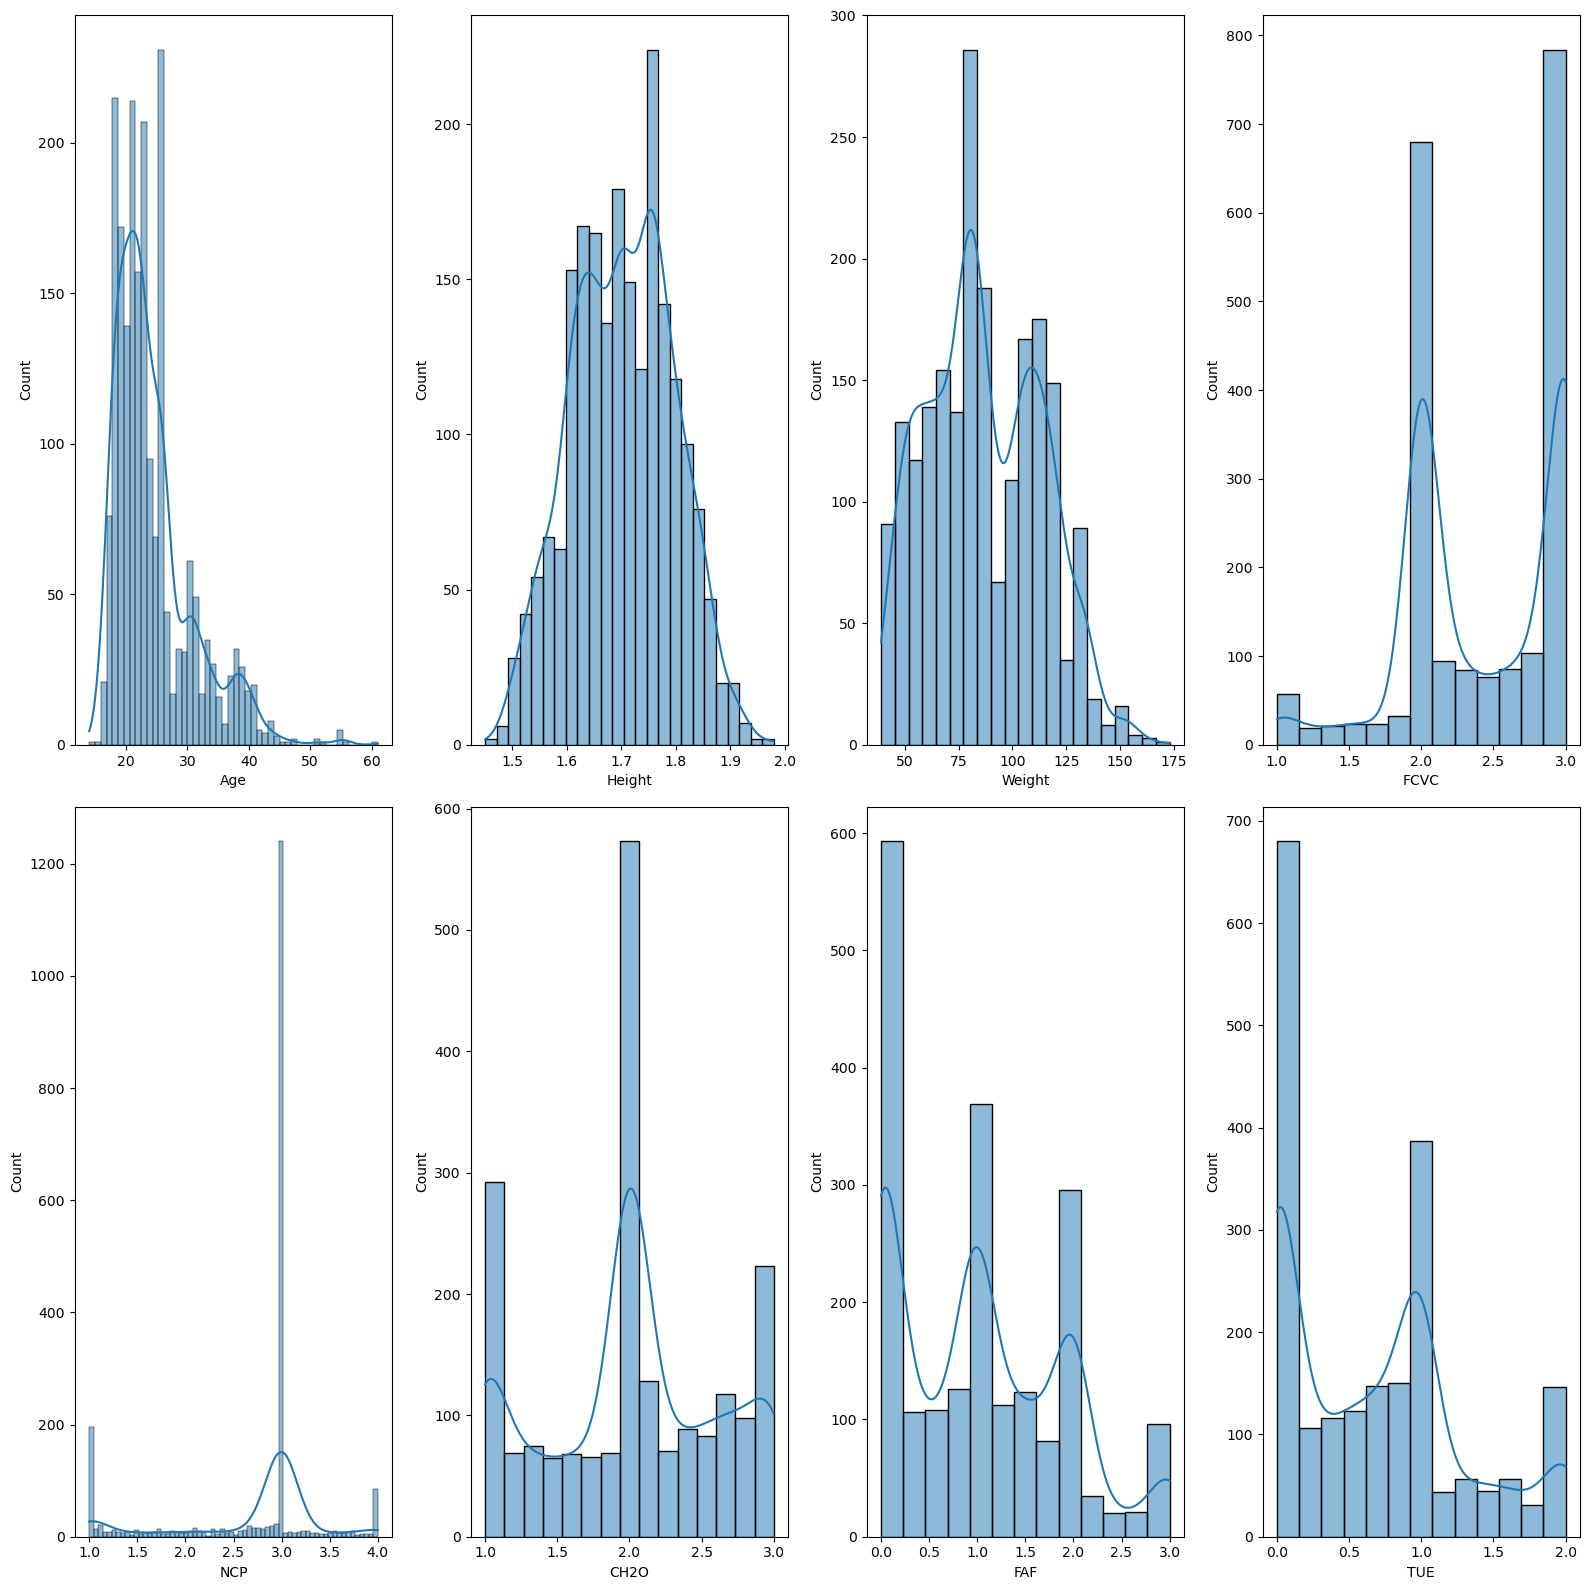

In [102]:
plt.figure(figsize=(16,16))
len_cols = len(continuous_features.columns)
rows = (len_cols +3)//4

for idx, col in enumerate(continuous_features.columns):
  plt.subplot(rows, 4, idx+1)
  sns.histplot(continuous_features[col], kde=True)
  plt.tight_layout()
  plt.plot()

# BoxPlot for continuous features

/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/1969400763.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/1969400763.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/1969400763.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/1969400763.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/1969400763.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/1969400763.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/d2/2759wj910z3_bl8zjx2l83tr0000gp/T/ipykernel_85368/19694

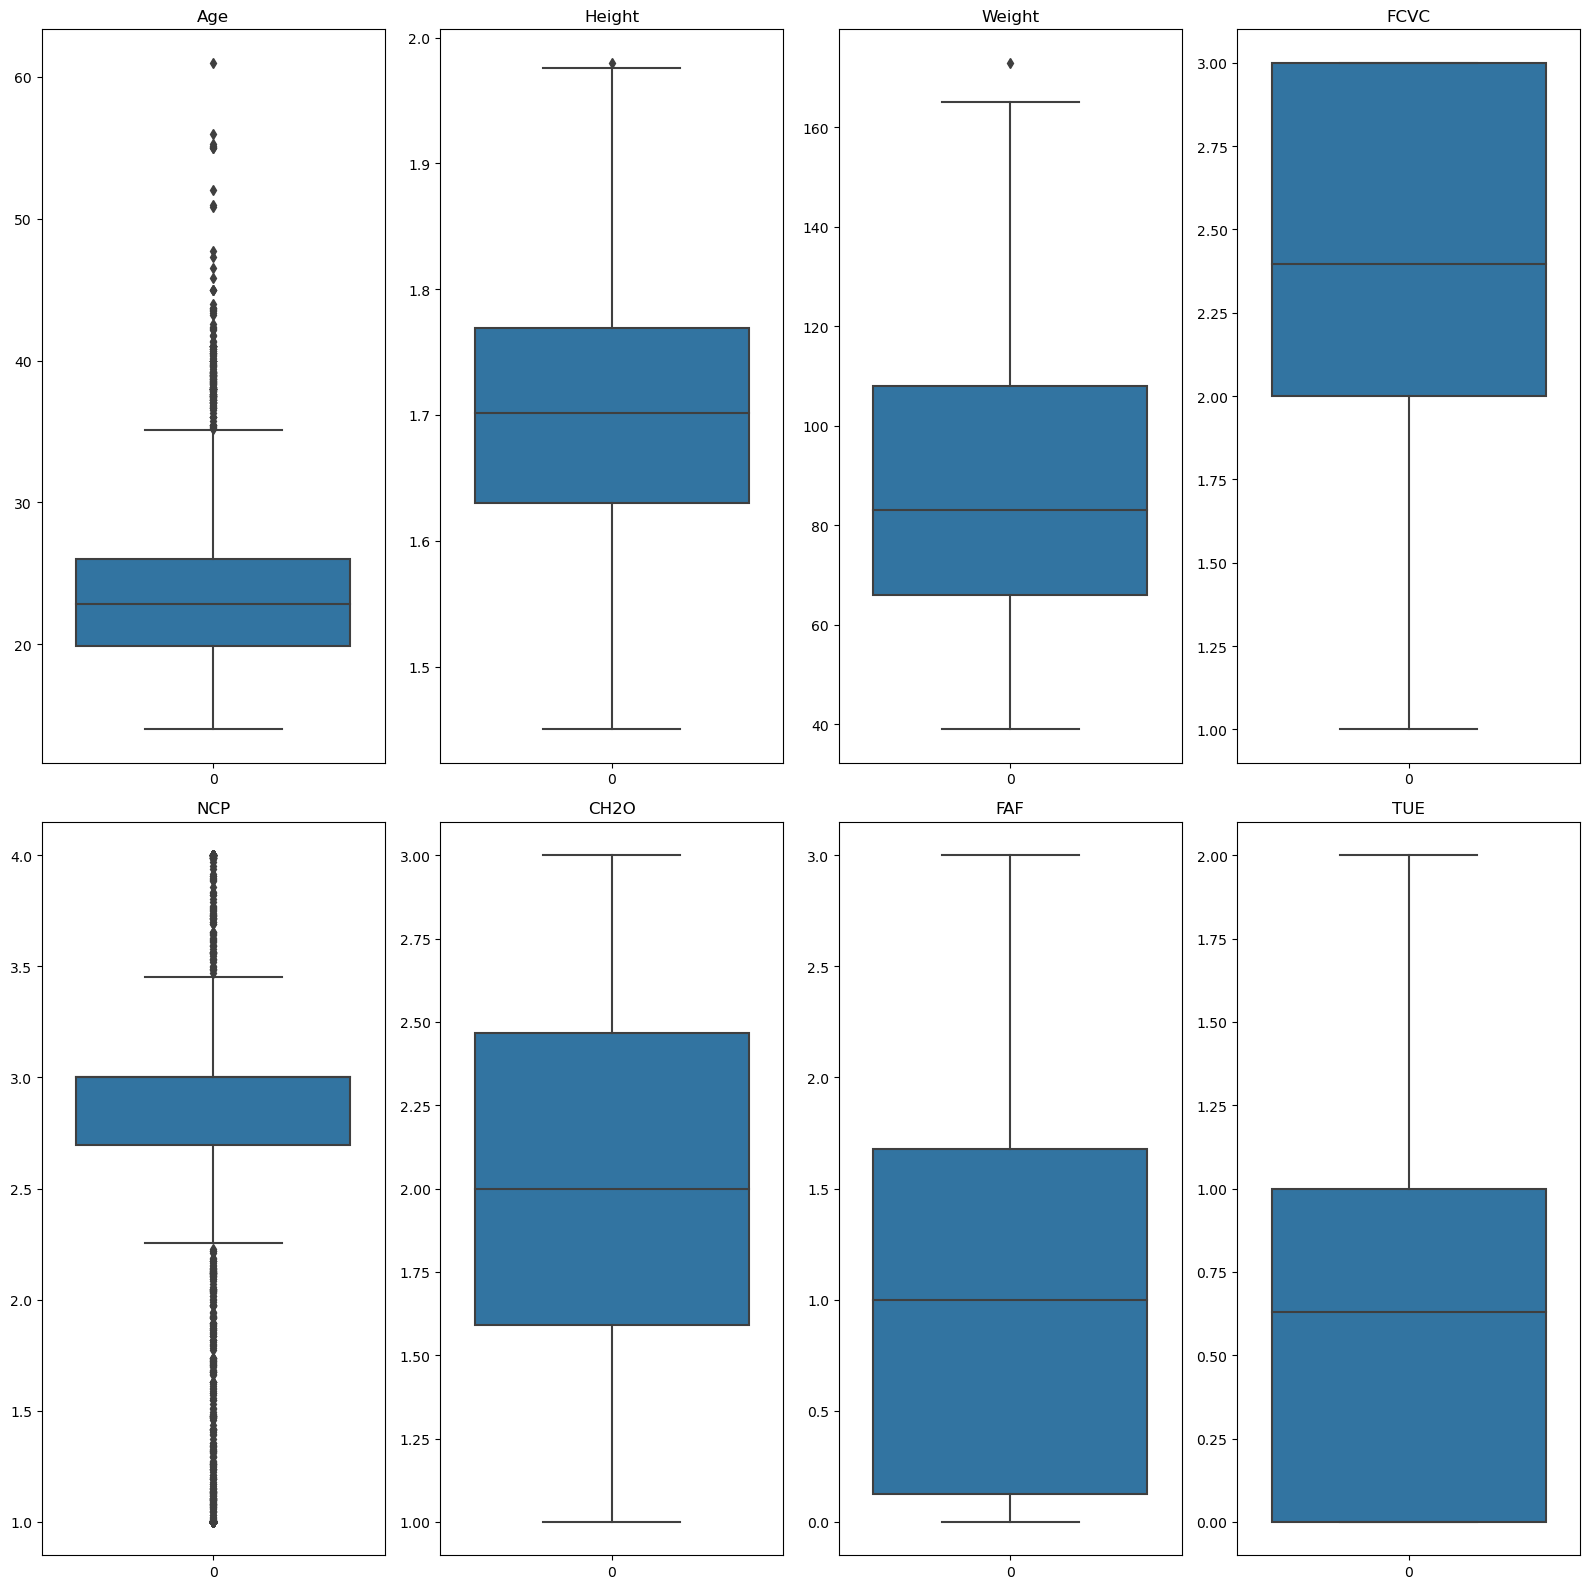

In [105]:
plt.figure(figsize=(16,16))
len_cols = len(continuous_features.columns)
rows = (len_cols +3)//4

for idx, col in enumerate(continuous_features.columns):
  plt.subplot(rows, 4, idx+1)
  plt.title(f"{col}")
  sns.boxplot(continuous_features[col])
  plt.tight_layout()
  plt.plot()

# Stacked Plots for categorical features

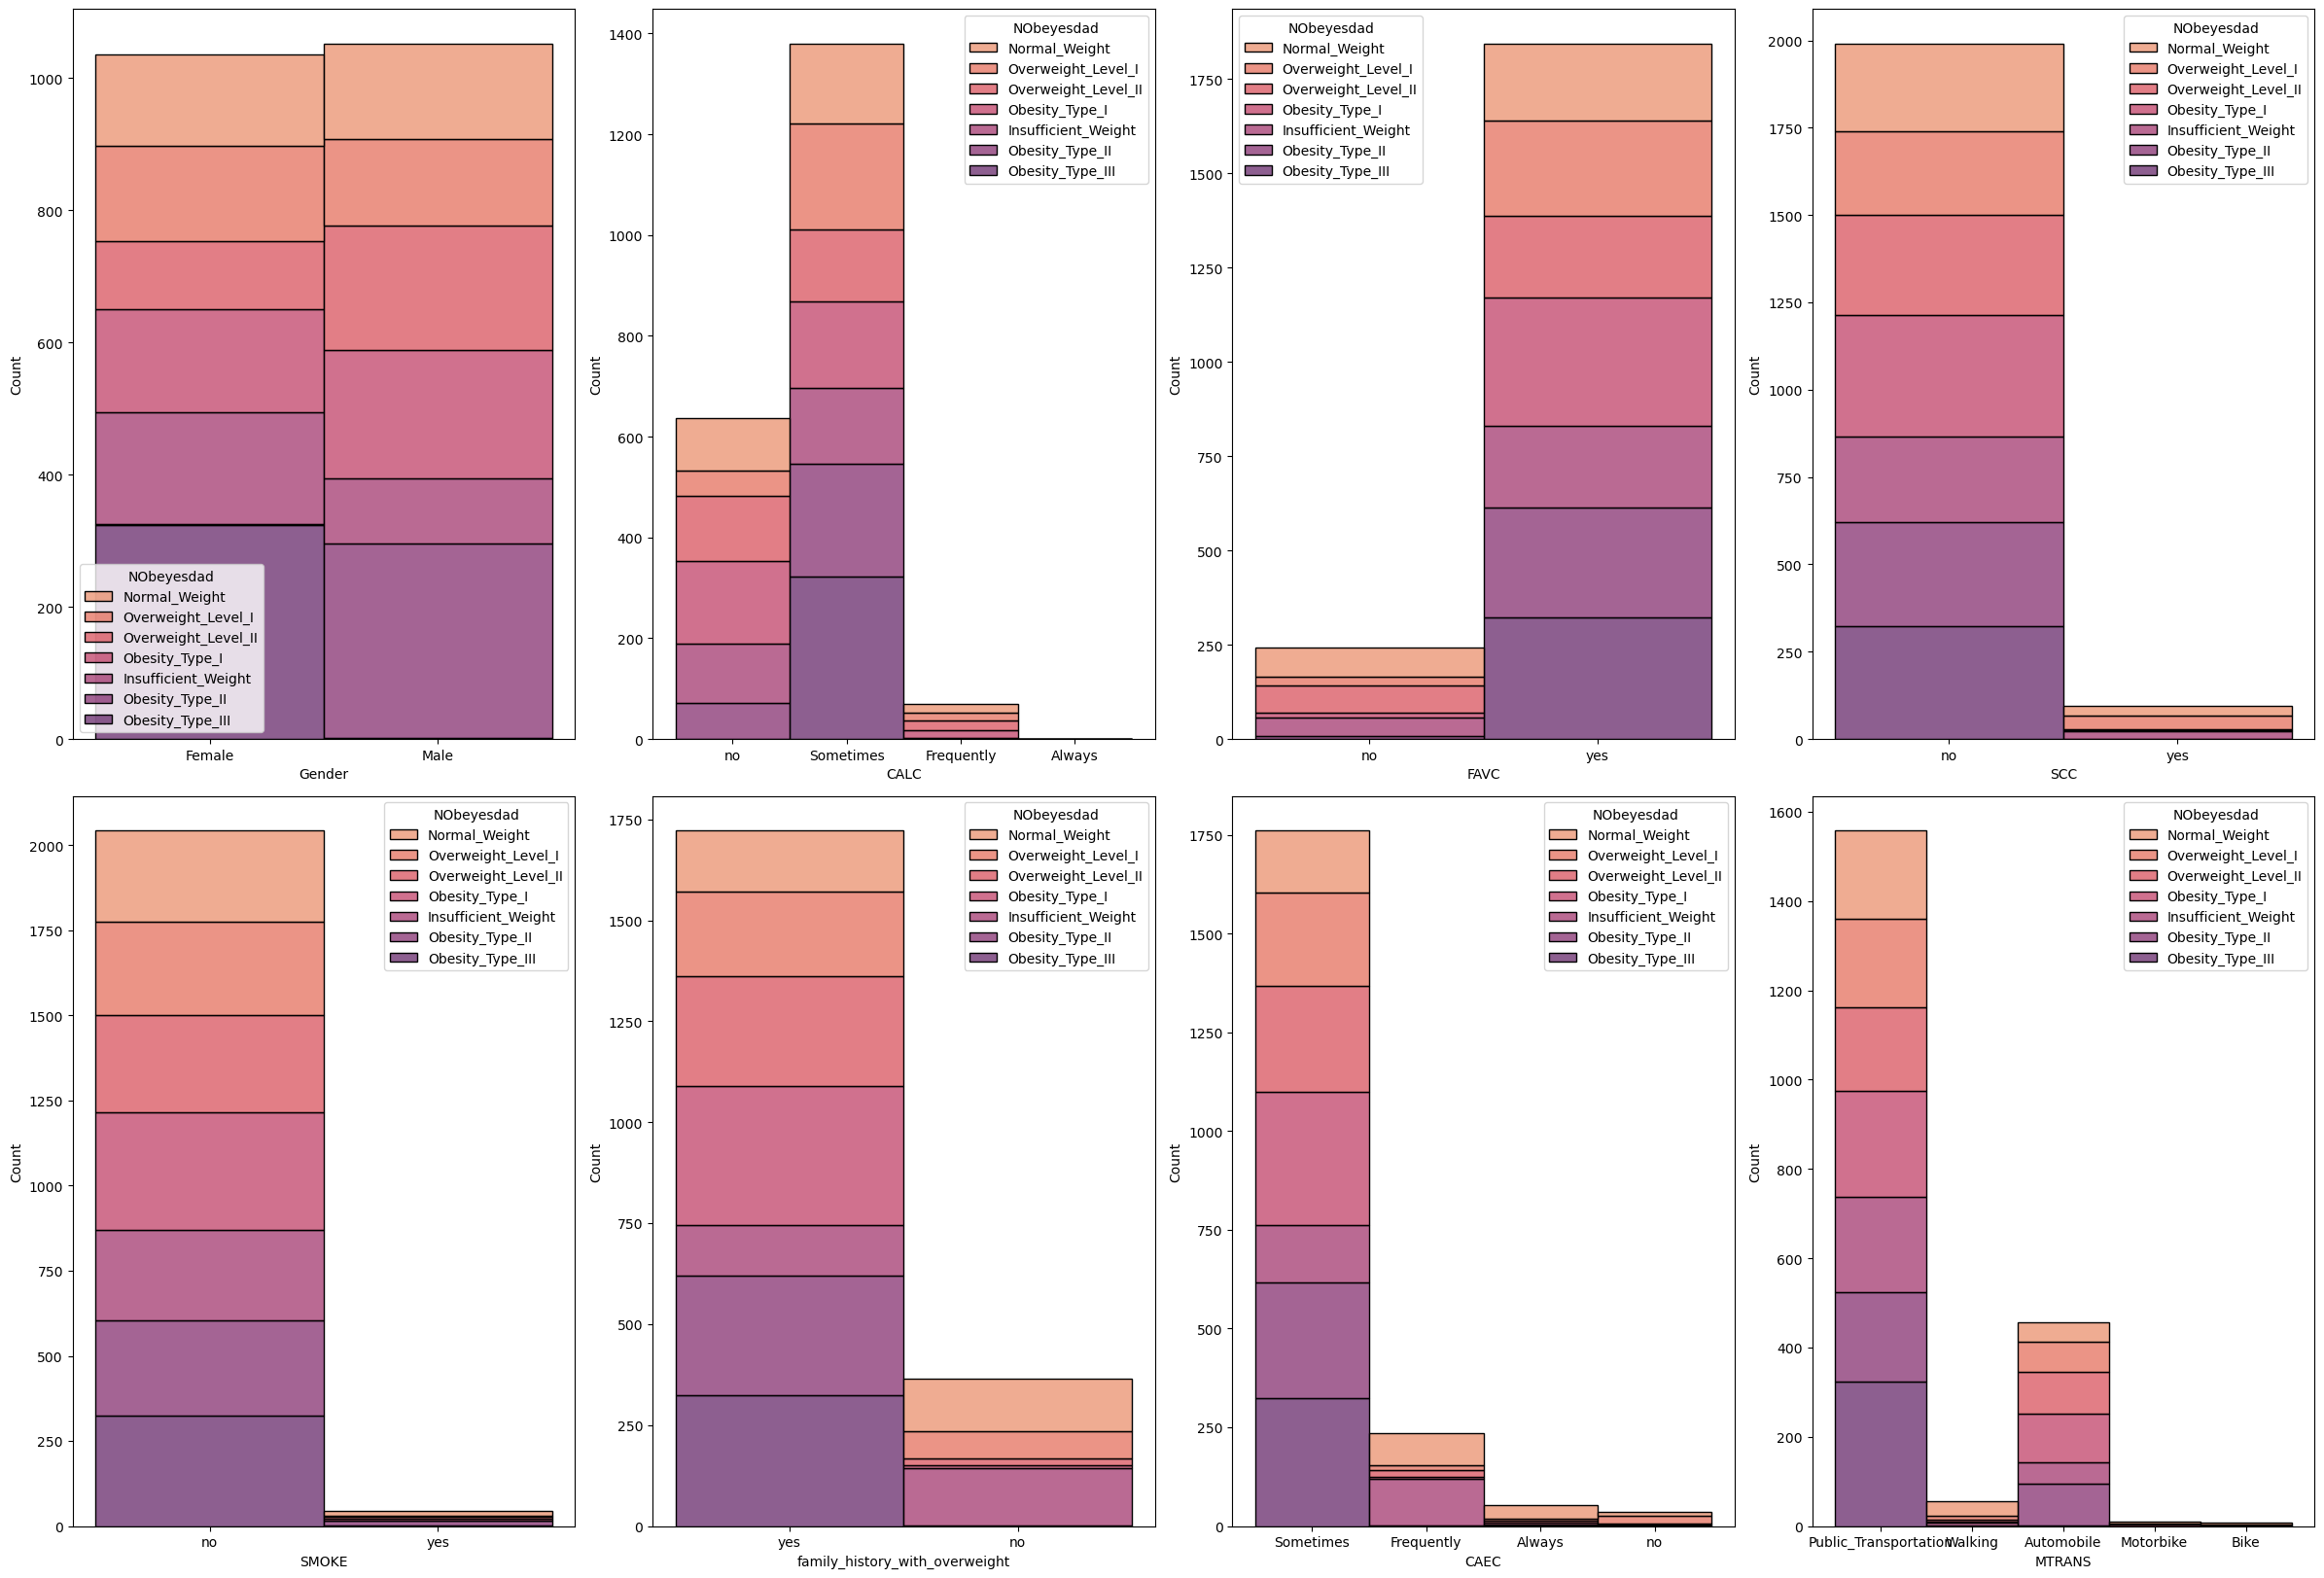

In [118]:
plt.figure(figsize=(24,24))
len_cols = len(categorical_features.columns)
rows = (len_cols + 3) // 4

for idx, col in enumerate(categorical_features.columns):
  if col == "NObeyesdad":
    break
  plt.subplot(rows, 4, idx+1)
  sns.histplot(data=categorical_features, x=col, hue='NObeyesdad', palette='flare', multiple='stack')
plt.tight_layout()
plt.show() 


# Baseline Model Evaluation

In [119]:
X,y = replicate_df.drop("NObeyesdad", axis=1), replicate_df["NObeyesdad"]

In [120]:
# define the reference model
model = DummyClassifier(strategy='uniform')
# evaluate the model
scores = evaluate_model(X, y, model, "accuracy")
# summarize performance
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.142 (0.028)


# Spot Check Algorithms

In [131]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
models = spot_check_models(X_train_scaled, X_test_scaled, y_train, y_test)
models

/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


14/14 [==============================] - 0s 562us/step - loss: 0.0000e+00 - accuracy: 0.1459


,Model,Accuracy
9,XGB,0.973684
7,RandomForestClassifier,0.966507
8,GradientBoostingClassifier,0.949761
6,DecisionTreeClassifier,0.918660
1,LDA,0.889952
4,SVC,0.885167
3,LogisticRegression,0.866029
2,GPC,0.813397
5,KNeighborsClassifier,0.801435
0,GaussianNB,0.581340


# Advanced Model Metrics

In [134]:
names = ["XGB", "DTC", "GBC", "RFC", "LDA", "SVC", "LR"]
models = get_selected_models(names)

for i in range(len(models)):
  pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', models[i])])
  # Evaluate the model
  scores = evaluate_model(X, y, pipeline, "accuracy")
  # summarize and store
  print('>%s %.3f (%.3f)' % (names[i], np.mean(scores), np.std(scores)))

>XGB 0.914 (0.018)
>DTC 0.891 (0.019)


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.888 (0.020)
>RFC 0.933 (0.017)
>LDA 0.966 (0.013)
>SVC 0.953 (0.015)
>LR 0.972 (0.012)


# Advanced Model Analysis: When the values are power transformed to be more Gaussian like, we see a bump in performance for SVC and LR. Since we trained on multiple subsets of data. We see which are the highest performing models across each subset.

# Feature Importance: We will use ANOVA and Mutual Information tests to decipher if we can gain any more model performance by reducing dimensionality while maintaining accuracy.

In [151]:
from sklearn.feature_selection import SelectKBest, f_classif

names = ["XGB", "DTC", "GBC", "RFC", "LDA", "SVC", "LR"]
models = get_selected_models(names)
num_features = [i for i in range(8, X.shape[1]+1)]
# Model Performance:
model_performance = []
for k in num_features:
  # create pipeline
  model = models[i]
  fs = SelectKBest(score_func=f_classif, k=k)
  for i in range(len(models)):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()),("power_tranformer", PowerTransformer()), ('anova',fs), ('model', models[i])])
    scores = evaluate_model(X, y, pipeline, "accuracy")
    print('>%s %.3f (%.3f) k=%d' % (names[i], np.mean(scores), np.std(scores), k))
    print("---------------------------------------------------------------")
    model_performance.append({
            "Model": models[i],
            "mean": np.mean(scores),
            "std":np.std(scores),
            "iteration":k
        })
model_performance = pd.DataFrame(model_performance)
model_performance[model_performance["mean"] >= 95.0]

>XGB 0.916 (0.023) k=8
---------------------------------------------------------------
>DTC 0.894 (0.021) k=8
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.895 (0.022) k=8
---------------------------------------------------------------
>RFC 0.943 (0.014) k=8
---------------------------------------------------------------
>LDA 0.967 (0.011) k=8
---------------------------------------------------------------
>SVC 0.945 (0.014) k=8
---------------------------------------------------------------
>LR 0.973 (0.009) k=8
---------------------------------------------------------------
>XGB 0.915 (0.023) k=9
---------------------------------------------------------------
>DTC 0.892 (0.019) k=9
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.895 (0.023) k=9
---------------------------------------------------------------
>RFC 0.943 (0.016) k=9
---------------------------------------------------------------
>LDA 0.967 (0.012) k=9
---------------------------------------------------------------
>SVC 0.954 (0.015) k=9
---------------------------------------------------------------
>LR 0.973 (0.012) k=9
---------------------------------------------------------------
>XGB 0.915 (0.021) k=10
---------------------------------------------------------------
>DTC 0.898 (0.022) k=10
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.900 (0.021) k=10
---------------------------------------------------------------
>RFC 0.944 (0.013) k=10
---------------------------------------------------------------
>LDA 0.966 (0.011) k=10
---------------------------------------------------------------
>SVC 0.953 (0.016) k=10
---------------------------------------------------------------
>LR 0.973 (0.010) k=10
---------------------------------------------------------------
>XGB 0.916 (0.020) k=11
---------------------------------------------------------------
>DTC 0.893 (0.019) k=11
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.898 (0.021) k=11
---------------------------------------------------------------
>RFC 0.942 (0.015) k=11
---------------------------------------------------------------
>LDA 0.965 (0.013) k=11
---------------------------------------------------------------
>SVC 0.949 (0.017) k=11
---------------------------------------------------------------
>LR 0.973 (0.011) k=11
---------------------------------------------------------------
>XGB 0.916 (0.021) k=12
---------------------------------------------------------------
>DTC 0.891 (0.022) k=12
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.898 (0.020) k=12
---------------------------------------------------------------
>RFC 0.941 (0.016) k=12
---------------------------------------------------------------
>LDA 0.966 (0.012) k=12
---------------------------------------------------------------
>SVC 0.951 (0.015) k=12
---------------------------------------------------------------
>LR 0.973 (0.010) k=12
---------------------------------------------------------------
>XGB 0.913 (0.021) k=13
---------------------------------------------------------------
>DTC 0.887 (0.021) k=13
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.896 (0.019) k=13
---------------------------------------------------------------
>RFC 0.941 (0.015) k=13
---------------------------------------------------------------
>LDA 0.965 (0.013) k=13
---------------------------------------------------------------
>SVC 0.950 (0.018) k=13
---------------------------------------------------------------
>LR 0.972 (0.011) k=13
---------------------------------------------------------------
>XGB 0.911 (0.019) k=14
---------------------------------------------------------------
>DTC 0.887 (0.019) k=14
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.896 (0.019) k=14
---------------------------------------------------------------
>RFC 0.939 (0.015) k=14
---------------------------------------------------------------
>LDA 0.966 (0.013) k=14
---------------------------------------------------------------
>SVC 0.950 (0.017) k=14
---------------------------------------------------------------
>LR 0.973 (0.011) k=14
---------------------------------------------------------------
>XGB 0.912 (0.019) k=15
---------------------------------------------------------------
>DTC 0.893 (0.019) k=15
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.890 (0.019) k=15
---------------------------------------------------------------
>RFC 0.938 (0.014) k=15
---------------------------------------------------------------
>LDA 0.965 (0.014) k=15
---------------------------------------------------------------
>SVC 0.951 (0.018) k=15
---------------------------------------------------------------
>LR 0.972 (0.012) k=15
---------------------------------------------------------------
>XGB 0.914 (0.018) k=16
---------------------------------------------------------------
>DTC 0.891 (0.019) k=16
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.888 (0.020) k=16
---------------------------------------------------------------
>RFC 0.935 (0.017) k=16
---------------------------------------------------------------
>LDA 0.966 (0.013) k=16
---------------------------------------------------------------
>SVC 0.956 (0.014) k=16
---------------------------------------------------------------
>LR 0.972 (0.012) k=16
---------------------------------------------------------------


,Model,mean,std,iteration
34,"XGBClassifier(base_score=None, booster=None, c...",0.973333,0.010237,12
6,"XGBClassifier(base_score=None, booster=None, c...",0.973331,0.008878,8
13,"XGBClassifier(base_score=None, booster=None, c...",0.973014,0.011876,9
48,"XGBClassifier(base_score=None, booster=None, c...",0.973013,0.010732,14
20,"XGBClassifier(base_score=None, booster=None, c...",0.972695,0.010486,10
27,"XGBClassifier(base_score=None, booster=None, c...",0.972693,0.010780,11
55,"XGBClassifier(base_score=None, booster=None, c...",0.972214,0.011614,15
41,"XGBClassifier(base_score=None, booster=None, c...",0.971897,0.011096,13
62,"XGBClassifier(base_score=None, booster=None, c...",0.971894,0.012091,16
4,GradientBoostingClassifier(),0.967419,0.010604,8


In [153]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
names = ["XGB", "DTC", "GBC", "RFC", "LDA", "SVC", "LR"]
models = get_selected_models(names)
num_features = [i for i in range(8, X.shape[1]+1)]
# Model Performance:
model_performance = []
for k in num_features:
  # create pipeline
  model = models[i]
  fs = SelectKBest(score_func=mutual_info_classif, k=k)
  for i in range(len(models)):
    pipeline = Pipeline(steps=[('scaler', StandardScaler()),("power_tranformer", PowerTransformer()), ('mutual_information',fs), ('model', models[i])])
    scores = evaluate_model(X, y, pipeline, "accuracy")
    print('>%s %.3f (%.3f) k=%d' % (names[i], np.mean(scores), np.std(scores), k))
    print("---------------------------------------------------------------")
    model_performance.append({
            "Model": models[i],
            "mean": np.mean(scores),
            "std":np.std(scores),
            "iteration":k
        })
model_performance = pd.DataFrame(model_performance)
model_performance[model_performance["mean"] >= 95.0]

>XGB 0.896 (0.021) k=8
---------------------------------------------------------------
>DTC 0.914 (0.017) k=8
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


>GBC 0.888 (0.027) k=8
---------------------------------------------------------------
>RFC 0.941 (0.016) k=8
---------------------------------------------------------------
>LDA 0.967 (0.013) k=8
---------------------------------------------------------------
>SVC 0.956 (0.013) k=8
---------------------------------------------------------------
>LR 0.971 (0.013) k=8
---------------------------------------------------------------
>XGB 0.904 (0.023) k=9
---------------------------------------------------------------
>DTC 0.908 (0.019) k=9
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.886 (0.021) k=9
---------------------------------------------------------------
>RFC 0.940 (0.014) k=9
---------------------------------------------------------------
>LDA 0.966 (0.013) k=9
---------------------------------------------------------------
>SVC 0.960 (0.015) k=9
---------------------------------------------------------------
>LR 0.972 (0.012) k=9
---------------------------------------------------------------
>XGB 0.909 (0.026) k=10
---------------------------------------------------------------
>DTC 0.900 (0.019) k=10
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.891 (0.023) k=10
---------------------------------------------------------------
>RFC 0.940 (0.014) k=10
---------------------------------------------------------------
>LDA 0.967 (0.014) k=10
---------------------------------------------------------------
>SVC 0.958 (0.012) k=10
---------------------------------------------------------------
>LR 0.973 (0.010) k=10
---------------------------------------------------------------
>XGB 0.915 (0.023) k=11
---------------------------------------------------------------
>DTC 0.903 (0.018) k=11
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.891 (0.024) k=11
---------------------------------------------------------------
>RFC 0.939 (0.015) k=11
---------------------------------------------------------------
>LDA 0.966 (0.013) k=11
---------------------------------------------------------------
>SVC 0.956 (0.017) k=11
---------------------------------------------------------------
>LR 0.973 (0.011) k=11
---------------------------------------------------------------
>XGB 0.910 (0.022) k=12
---------------------------------------------------------------
>DTC 0.907 (0.019) k=12
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.892 (0.022) k=12
---------------------------------------------------------------
>RFC 0.939 (0.015) k=12
---------------------------------------------------------------
>LDA 0.965 (0.014) k=12
---------------------------------------------------------------
>SVC 0.952 (0.014) k=12
---------------------------------------------------------------
>LR 0.973 (0.012) k=12
---------------------------------------------------------------
>XGB 0.910 (0.020) k=13
---------------------------------------------------------------
>DTC 0.908 (0.022) k=13
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.885 (0.024) k=13
---------------------------------------------------------------
>RFC 0.937 (0.015) k=13
---------------------------------------------------------------
>LDA 0.963 (0.014) k=13
---------------------------------------------------------------
>SVC 0.954 (0.015) k=13
---------------------------------------------------------------
>LR 0.972 (0.011) k=13
---------------------------------------------------------------
>XGB 0.911 (0.021) k=14
---------------------------------------------------------------
>DTC 0.897 (0.019) k=14
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.890 (0.020) k=14
---------------------------------------------------------------
>RFC 0.936 (0.017) k=14
---------------------------------------------------------------
>LDA 0.965 (0.012) k=14
---------------------------------------------------------------
>SVC 0.953 (0.017) k=14
---------------------------------------------------------------
>LR 0.973 (0.010) k=14
---------------------------------------------------------------
>XGB 0.913 (0.019) k=15
---------------------------------------------------------------
>DTC 0.892 (0.018) k=15
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.890 (0.019) k=15
---------------------------------------------------------------
>RFC 0.934 (0.015) k=15
---------------------------------------------------------------
>LDA 0.966 (0.012) k=15
---------------------------------------------------------------
>SVC 0.953 (0.017) k=15
---------------------------------------------------------------
>LR 0.973 (0.012) k=15
---------------------------------------------------------------
>XGB 0.914 (0.018) k=16
---------------------------------------------------------------
>DTC 0.891 (0.019) k=16
---------------------------------------------------------------


/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/test/miniforge3/envs/machine-learning-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lear

>GBC 0.888 (0.020) k=16
---------------------------------------------------------------
>RFC 0.933 (0.016) k=16
---------------------------------------------------------------
>LDA 0.966 (0.013) k=16
---------------------------------------------------------------
>SVC 0.956 (0.015) k=16
---------------------------------------------------------------
>LR 0.972 (0.012) k=16
---------------------------------------------------------------


,Model,mean,std,iteration


In [158]:
model_performance[model_performance["mean"] >0.95]

,Model,mean,std,iteration
4,GradientBoostingClassifier(),0.967264,0.012793,8
5,RandomForestClassifier(),0.956234,0.013266,8
6,"XGBClassifier(base_score=None, booster=None, c...",0.971417,0.012511,8
11,GradientBoostingClassifier(),0.965986,0.012506,9
12,RandomForestClassifier(),0.960387,0.014953,9
13,"XGBClassifier(base_score=None, booster=None, c...",0.971574,0.012422,9
18,GradientBoostingClassifier(),0.967264,0.013938,10
19,RandomForestClassifier(),0.957834,0.012203,10
20,"XGBClassifier(base_score=None, booster=None, c...",0.973331,0.010395,10
25,GradientBoostingClassifier(),0.966146,0.013195,11
